In [22]:
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, average_precision_score, precision_recall_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.externals.six import StringIO  
from IPython.display import Image  

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import export_graphviz

import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pydot
import scikitplot as skplt


import os
import subprocess

import warnings; warnings.simplefilter('ignore')
%matplotlib inline

bank_data = pd.read_csv('bank-additional-full.csv')

In [23]:
#Handling categorical variables
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','day_of_week', 'poutcome', 'y']
bank_data_tran = pd.get_dummies(bank_data, columns = categorical_features, drop_first=True)

bank_data_tran.drop(['duration'], axis = 1, inplace = True)
bank_data_tran.drop(['job_blue-collar', 'job_self-employed', 'job_services', 'job_unemployed', 'day_of_week_mon'], axis = 1, inplace = True)
#because of the high correlation coefficient between euribor3m rate and nr. of employed, the latter is going to be dropped
bank_data_tran.drop(['nr.employed'], axis = 1, inplace = True)

#apllying the same logic, emp.var.rate is going to be dropped
bank_data_tran.drop(['emp.var.rate'], axis = 1, inplace = True)

In [24]:
#Function for printing results
def print_results(x_input, true_output, predicted_output, classifier):
    precision, recall, thresholds = precision_recall_curve(true_output, classifier.predict_proba(x_input)[:,1])
    area = auc(recall, precision)
    print("\nArea under precission-recall is:", area)
    
    print("Validation set predictions: \n\n" + classification_report(true_output,predicted_output))
    print("\n Confusion matrix:\n " , confusion_matrix(true_output, predicted_output))
    print("\n")
    print("True negatives:", confusion_matrix(true_output, predicted_output)[0][0])
    print("False positives:", confusion_matrix(true_output, predicted_output)[0][1])
    print("False negatives:", confusion_matrix(true_output, predicted_output)[1][0])
    print("True positives: ", confusion_matrix(true_output, predicted_output)[1][1])

In [25]:
#Data preprocessing and splitting and scaling
msk = np.random.rand(len(bank_data_tran)) < 0.8

train = bank_data_tran[msk]
test = bank_data_tran[~msk]

msk2 = np.random.rand(len(train)) < 0.8

train2 = train[msk2]
val = train[~msk2]


x = bank_data_tran.iloc[:,bank_data_tran.columns != 'y_yes'].values
y = bank_data_tran.iloc[:, -1].values

In [26]:
#Downsampled

# Separate majority and minority classes
df_majority = train2[train2.y_yes ==0]
df_minority = train2[train2.y_yes ==1]

In [27]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=5000,     # to match minority class
                                 random_state=123) # reproducible results

In [28]:
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [29]:
df_downsampled.y_yes.value_counts()

0    5000
1    2976
Name: y_yes, dtype: int64

In [30]:
#Data preprocessing and splitting 
x_down = df_downsampled.iloc[:,df_downsampled.columns != 'y_yes'].values
y_down = df_downsampled.iloc[:, -1].values

x_train = x_down
y_train = y_down

x_val = val.iloc[:, val.columns != 'y_yes'].values
y_val = val.iloc[:, -1].values

x_test = test.iloc[:, test.columns!='y_yes'].values
y_test = test.iloc[:, -1].values

# Decision tree
   - <h4> Model training </h4>

In [31]:
#Decision tree algorithm
td_classifier = DecisionTreeClassifier(criterion='entropy', random_state = 0)
td_classifier.fit(x_train, y_train)

predictions_DT_val = td_classifier.predict(x_val)

#Results 
print_results(x_val, y_val, predictions_DT_val, td_classifier)


Area under precission-recall is: 0.4064777984543906
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.93      0.73      0.82      5846
          1       0.20      0.56      0.30       724

avg / total       0.85      0.71      0.76      6570


 Confusion matrix:
  [[4274 1572]
 [ 319  405]]


True negatives: 4274
False positives: 1572
False negatives: 319
True positives:  405


- <h4> Model testing </h4>

In [32]:
predictions_DT_test = td_classifier.predict(x_test)
print_results(x_test, y_test, predictions_DT_test, td_classifier)


Area under precission-recall is: 0.4121023185153822
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.93      0.74      0.83      7321
          1       0.22      0.56      0.31       940

avg / total       0.85      0.72      0.77      8261


 Confusion matrix:
  [[5450 1871]
 [ 416  524]]


True negatives: 5450
False positives: 1871
False negatives: 416
True positives:  524


Area under Reciver Operating Characteristic Curve is:  0.6509403145134807


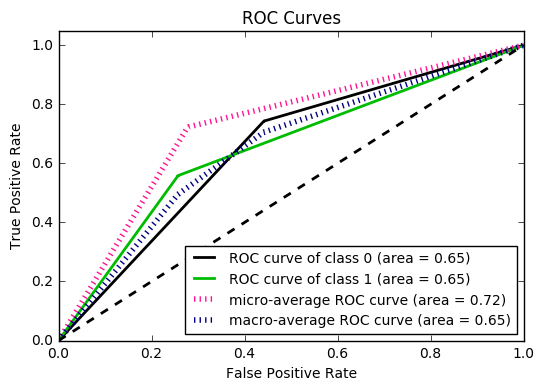

In [33]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, predictions_DT_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = td_classifier.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

# AdaBoost
- <h4> Model training </h4>

In [34]:
#Boosting - AdaBoost
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20),
                         algorithm = "SAMME",
                         n_estimators=200)
                         
ada.fit(x_train, y_train)
predictions_ada = ada.predict(x_val)

print_results(x_val, y_val, predictions_ada, ada)


Area under precission-recall is: 0.34627504695225736
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.94      0.83      0.88      5846
          1       0.30      0.60      0.40       724

avg / total       0.87      0.80      0.83      6570


 Confusion matrix:
  [[4834 1012]
 [ 289  435]]


True negatives: 4834
False positives: 1012
False negatives: 289
True positives:  435


- <h4> Model testing </h4>

In [35]:
predictions_ada_test = ada.predict(x_test)
print_results(x_test, y_test, predictions_ada_test, ada)


Area under precission-recall is: 0.3348360263809339
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.94      0.83      0.88      7321
          1       0.30      0.56      0.39       940

avg / total       0.86      0.80      0.83      8261


 Confusion matrix:
  [[6093 1228]
 [ 414  526]]


True negatives: 6093
False positives: 1228
False negatives: 414
True positives:  526


Area under Reciver Operating Characteristic Curve is:  0.6959189100430995


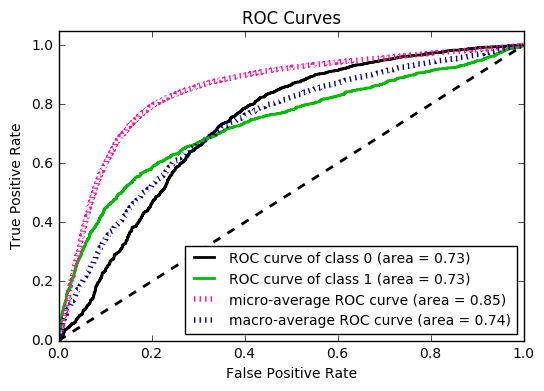

In [36]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, predictions_ada_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = ada.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

# Gradient Boosting  Classifier
- <h4> Model training </h4>

In [37]:
#Gradient boosting
gradientBoost = GradientBoostingClassifier(n_estimators=100, random_state=1)
gradientBoost.fit(x_train, y_train)

gradient_predictions = gradientBoost.predict(x_val)

#Results
print_results(x_val, y_val, gradient_predictions, gradientBoost)


Area under precission-recall is: 0.4340823598034404
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.95      0.90      0.92      5846
          1       0.41      0.58      0.48       724

avg / total       0.89      0.86      0.87      6570


 Confusion matrix:
  [[5248  598]
 [ 303  421]]


True negatives: 5248
False positives: 598
False negatives: 303
True positives:  421


- <h4> Model testing </h4>

In [38]:
predictions_GradB_test = gradientBoost.predict(x_test)
print_results(x_test, y_test, predictions_GradB_test, classifier=gradientBoost)


Area under precission-recall is: 0.43285609577496276
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.94      0.90      0.92      7321
          1       0.41      0.56      0.48       940

avg / total       0.88      0.86      0.87      8261


 Confusion matrix:
  [[6570  751]
 [ 410  530]]


True negatives: 6570
False positives: 751
False negatives: 410
True positives:  530


Area under Reciver Operating Characteristic Curve is:  0.7306240863502544


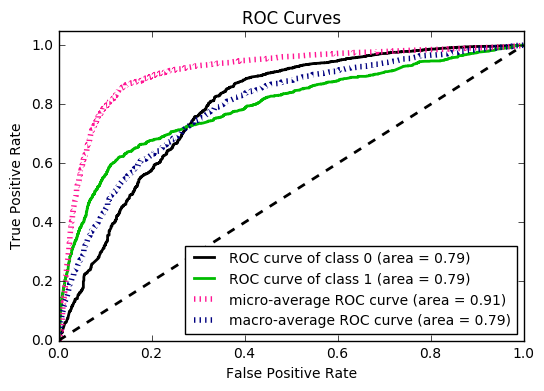

In [39]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, predictions_GradB_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = gradientBoost.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

# Decision Tree Bagging
- <h4> Model training </h4>

In [40]:
#Bagging with decission trees
bagg = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=20), n_estimators=100, random_state=7)
bagg.fit(x_train, y_train)

predictions_bag = bagg.predict(x_val)

#Results
print_results(x_val, y_val, predictions_bag, bagg)


Area under precission-recall is: 0.40487266400913496
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.94      0.87      0.91      5846
          1       0.36      0.57      0.44       724

avg / total       0.88      0.84      0.86      6570


 Confusion matrix:
  [[5107  739]
 [ 311  413]]


True negatives: 5107
False positives: 739
False negatives: 311
True positives:  413


- <h4> Model testing </h4>

In [41]:
predictions_bagg_test = bagg.predict(x_test)
print_results(x_test, y_test, predictions_bagg_test, bagg)


Area under precission-recall is: 0.39913308623594657
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.94      0.87      0.91      7321
          1       0.36      0.56      0.44       940

avg / total       0.87      0.84      0.85      8261


 Confusion matrix:
  [[6403  918]
 [ 415  525]]


True negatives: 6403
False positives: 918
False negatives: 415
True positives:  525


Area under Reciver Operating Characteristic Curve is:  0.7165589661916899


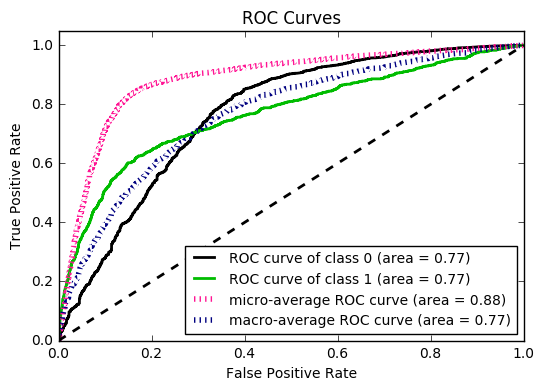

In [42]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, predictions_bagg_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = bagg.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

# Random Forest Classifier
- <h4> Model training </h4>

In [43]:
#Random Forest Classification Algorithm

# Fitting Random Forest Classification to the Training set
rf_classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 0)
rf_classifier.fit(x_train, y_train)

# Predicting the Test set results
predictions_RF_val = rf_classifier.predict(x_val)

#Results
print_results(x_val, y_val, predictions_RF_val, rf_classifier)


Area under precission-recall is: 0.41549650798715754
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.95      0.87      0.91      5846
          1       0.36      0.60      0.45       724

avg / total       0.88      0.84      0.86      6570


 Confusion matrix:
  [[5080  766]
 [ 293  431]]


True negatives: 5080
False positives: 766
False negatives: 293
True positives:  431


- <h4> Model testing </h4>

In [44]:
predictions_RF_test = rf_classifier.predict(x_test)
print_results(x_test, y_test, predictions_RF_test, rf_classifier)


Area under precission-recall is: 0.39286674702555857
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.94      0.87      0.91      7321
          1       0.37      0.58      0.45       940

avg / total       0.88      0.84      0.85      8261


 Confusion matrix:
  [[6392  929]
 [ 396  544]]


True negatives: 6392
False positives: 929
False negatives: 396
True positives:  544


Area under Reciver Operating Characteristic Curve is:  0.7259140856818188


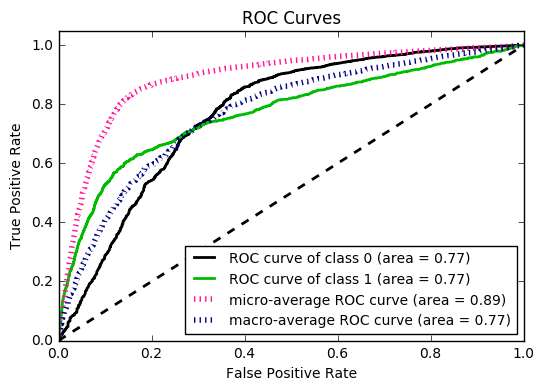

In [45]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, predictions_RF_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = rf_classifier.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

In [46]:
# Feature Scaling, because it isn't needed for Random Forest and Decision trees
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

# Logistic Regression Classifier
- <h4> Model training 

In [47]:
#Logistic Regression Algorithm
logdown = LogisticRegression(class_weight = 'balanced')
logdown.fit(x_train, y_train)
predictions_LR = logdown.predict(x_val)

#Results
print_results(x_val, y_val, predictions_LR, logdown)


Area under precission-recall is: 0.4272186143706622
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.95      0.83      0.89      5846
          1       0.31      0.62      0.42       724

avg / total       0.88      0.81      0.83      6570


 Confusion matrix:
  [[4858  988]
 [ 274  450]]


True negatives: 4858
False positives: 988
False negatives: 274
True positives:  450


- <h4> Model testing


In [48]:
predictions_LR_test = logdown.predict(x_test)
print_results(x_test, y_test, predictions_LR_test, logdown)


Area under precission-recall is: 0.4176257641075934
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.95      0.83      0.88      7321
          1       0.32      0.63      0.43       940

avg / total       0.87      0.81      0.83      8261


 Confusion matrix:
  [[6075 1246]
 [ 348  592]]


True negatives: 6075
False positives: 1246
False negatives: 348
True positives:  592


Area under Reciver Operating Characteristic Curve is:  0.7297959527677593


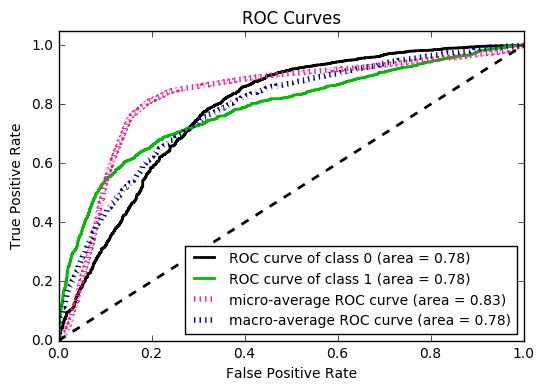

In [49]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, predictions_LR_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = logdown.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

# Support Vector Machines Classifier
- <h4> Model training 

In [50]:
#SVM algorithm

svm_classifier = SVC(kernel = 'rbf', random_state = 0, probability = True)
svm_classifier.fit(x_train, y_train)
predictions_SVC_val = svm_classifier.predict(x_val)

#Results
print_results(x_val, y_val, predictions_SVC_val, svm_classifier)
roc_auc_score(y_val, predictions_SVC_val, average='macro', sample_weight=None)


Area under precission-recall is: 0.37494052266776806
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.94      0.89      0.92      5846
          1       0.40      0.58      0.47       724

avg / total       0.89      0.86      0.87      6570


 Confusion matrix:
  [[5227  619]
 [ 306  418]]


True negatives: 5227
False positives: 619
False negatives: 306
True positives:  418


0.7357318504601531

- <h4> Model testing

In [51]:
predictions_SVM_test = svm_classifier.predict(x_test)

#Results
print_results(x_test, y_test, predictions_SVM_test, svm_classifier)


Area under precission-recall is: 0.3798718249072095
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.94      0.89      0.92      7321
          1       0.41      0.56      0.47       940

avg / total       0.88      0.86      0.87      8261


 Confusion matrix:
  [[6550  771]
 [ 412  528]]


True negatives: 6550
False positives: 771
False negatives: 412
True positives:  528


Area under Reciver Operating Characteristic Curve is:  0.7281943229473941


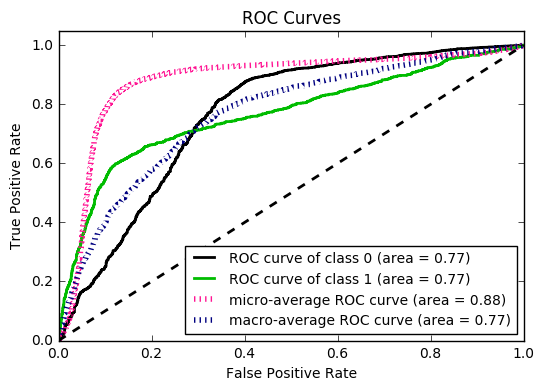

In [52]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, predictions_SVM_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = svm_classifier.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

# K-Nearest Neighbours Classifier
- <h4> Model training

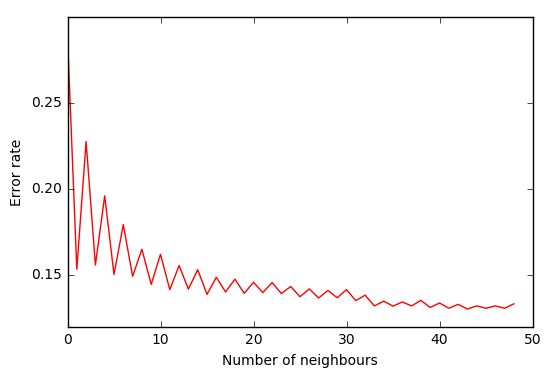

In [53]:
#KNN Algorithm
#adjusting parameters for KNN
error_rate = []

# Will take some time
for i in range(1,50):  
    knn_classifier = KNeighborsClassifier(n_neighbors=i, metric = 'minkowski', p = 2)
    knn_classifier.fit(x_train, y_train)
    pred_i = knn_classifier.predict(x_val)
    error_rate.append(np.mean(pred_i != y_val))
    
plt.xlabel("Number of neighbours")
plt.ylabel("Error rate")
plt.plot(error_rate, "r")

#predictions_KNN_test = knn_classifier.predict(x_test)
#print("Test set predictions:\n\n" + classification_report(y_test, predictions_KNN_test))

In [54]:
np.argmin(error_rate)

43

In [55]:
#From the plot above, we can see that the error_rate is smallest when number of neighbours is 17, so we take that K value
knn_classifier = KNeighborsClassifier(n_neighbors=45, metric = 'minkowski', p = 2)
knn_classifier.fit(x_train, y_train)
pred_i = knn_classifier.predict(x_val)

#Results
print_results(x_val, y_val, pred_i, knn_classifier)


Area under precission-recall is: 0.36490850588049634
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.93      0.92      0.93      5846
          1       0.41      0.44      0.43       724

avg / total       0.87      0.87      0.87      6570


 Confusion matrix:
  [[5382  464]
 [ 403  321]]


True negatives: 5382
False positives: 464
False negatives: 403
True positives:  321


- <h4> Model testing

In [56]:
predictions_KNN_test = knn_classifier.predict(x_test)
print_results(x_test, y_test, predictions_KNN_test, knn_classifier)


Area under precission-recall is: 0.38857745732772475
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.93      0.92      0.93      7321
          1       0.43      0.46      0.44       940

avg / total       0.87      0.87      0.87      8261


 Confusion matrix:
  [[6760  561]
 [ 511  429]]


True negatives: 6760
False positives: 561
False negatives: 511
True positives:  429


Area under Reciver Operating Characteristic Curve is:  0.6898770514433848


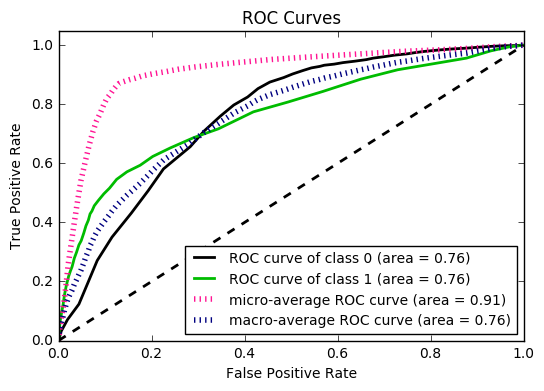

In [57]:
print("Area under Reciver Operating Characteristic Curve is: ", roc_auc_score(y_test, predictions_KNN_test, average='macro', sample_weight=None))
y_true = y_test
y_probas = knn_classifier.predict_proba(x_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

# Gaussian Naive Bayes Classifier
- <h4> Model training


In [45]:
# Gaussian Naive Bayes
gaussian_classifier = GaussianNB()
gaussian_classifier.fit(x_train, y_train)
#print(gaussian_classifier)
# make predictions
predicted = gaussian_classifier.predict(x_val)
# summarize the fit of the model

print_results(x_val, y_val, predicted, gaussian_classifier)


Area under precission-recall is: 0.44785155274595245
Validation set predictions: 

             precision    recall  f1-score   support

          0       0.95      0.55      0.69      5727
          1       0.19      0.78      0.30       776

avg / total       0.86      0.57      0.65      6503


 Confusion matrix:
  [[3129 2598]
 [ 169  607]]


True negatives: 3129
False positives: 2598
False negatives: 169
True positives:  607
